In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [68]:
df = pd.read_csv('../data/pzn-rent-train.csv')
#df = pd.read_csv('../data/pzn-rent-test.csv')

# Basic information
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()

print("\nMissing Values:")
missing_values = df.isnull().sum()
missing_percentages = (missing_values / len(df)) * 100
missing_stats = pd.DataFrame({
    'Missing Values': missing_values,
    'Missing Percentage': missing_percentages
})
print(missing_stats[missing_stats['Missing Values'] > 0].sort_values('Missing Percentage', ascending=False))


Dataset Shape: (11297, 36)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11297 entries, 0 to 11296
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  11297 non-null  int64  
 1   ad_title            11297 non-null  object 
 2   date_activ          11297 non-null  object 
 3   date_modif          11297 non-null  object 
 4   date_expire         11297 non-null  object 
 5   individual          10194 non-null  object 
 6   price               11297 non-null  int64  
 7   flat_area           10080 non-null  float64
 8   flat_rooms          10070 non-null  float64
 9   flat_furnished      9980 non-null   object 
 10  flat_rent           11297 non-null  int64  
 11  flat_deposit        11297 non-null  float64
 12  flat_for_students   9493 non-null   object 
 13  building_floor_num  11297 non-null  int64  
 14  flat_balcony        9929 non-null   object 
 15  flat_utilit

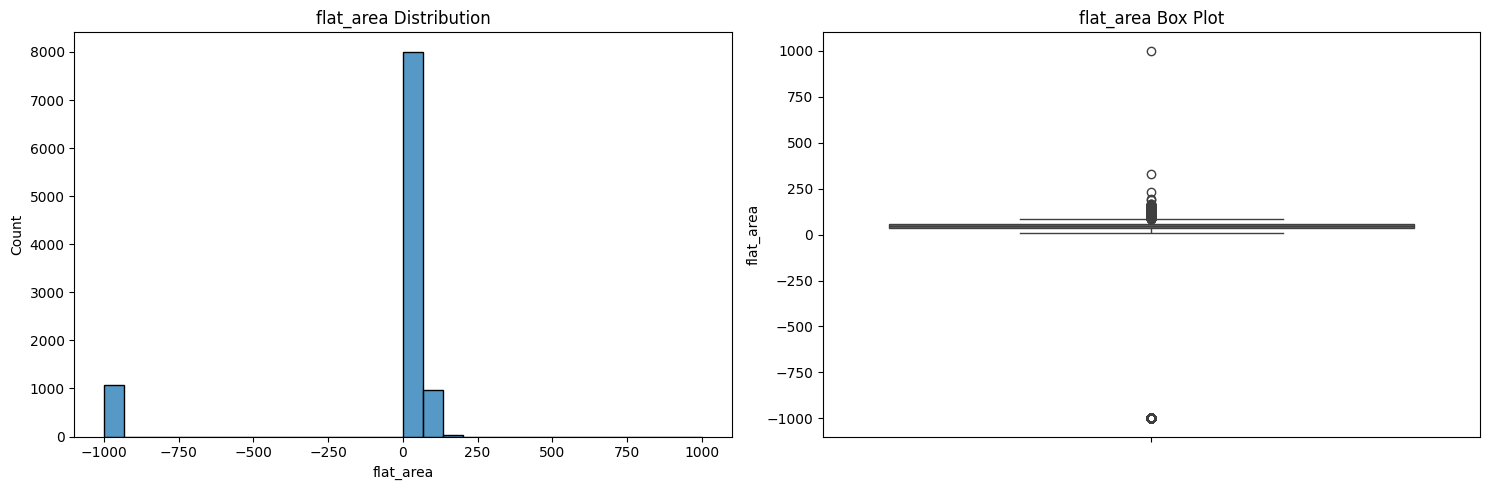

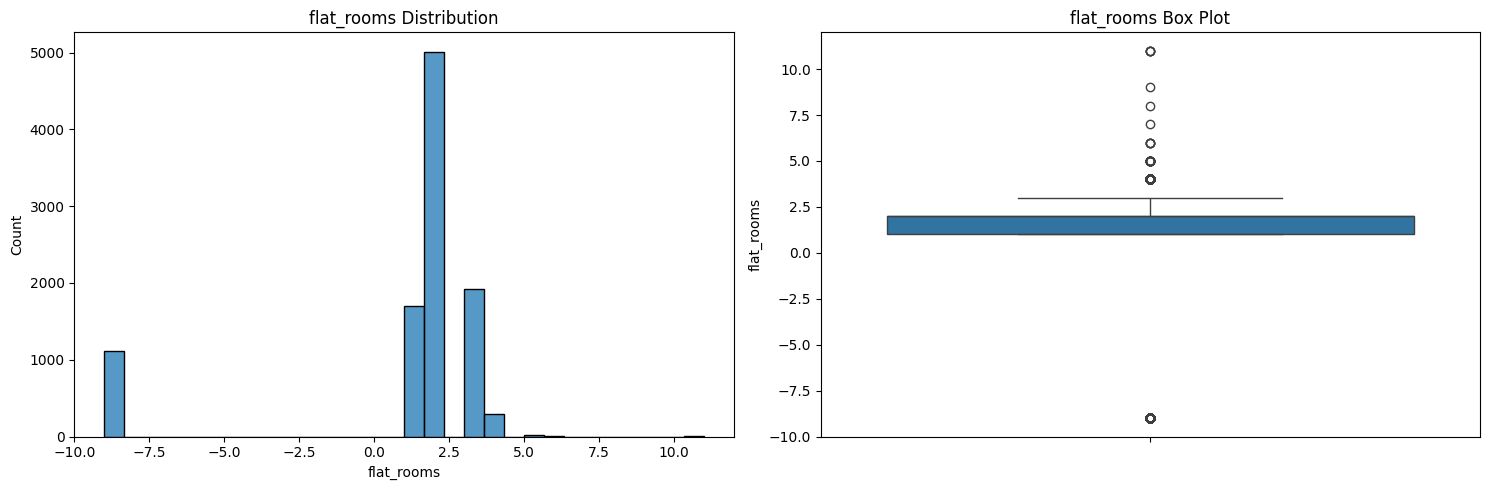

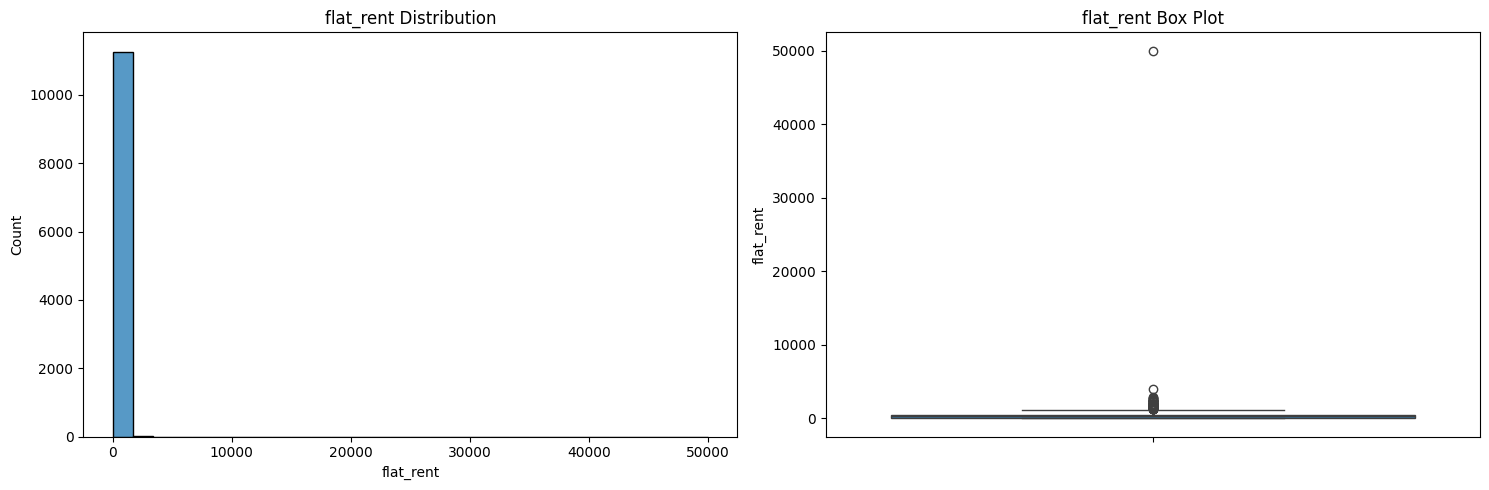

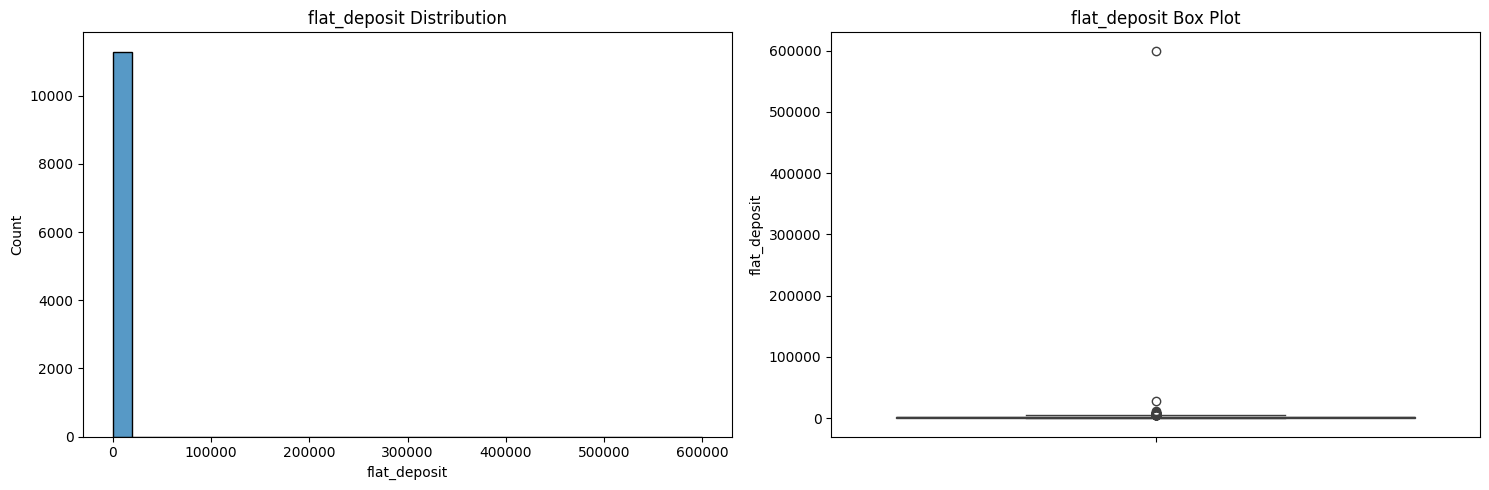

In [69]:
# Distribution analysis
def plot_numeric_distributions(df, columns, figsize=(15, 5)):
    """Plot distributions for numeric columns"""
    for col in columns:
        plt.figure(figsize=figsize)
        
        # Histogram
        plt.subplot(1, 2, 1)
        sns.histplot(data=df, x=col, bins=30)
        plt.title(f'{col} Distribution')
        
        # Box plot
        plt.subplot(1, 2, 2)
        sns.boxplot(data=df, y=col)
        plt.title(f'{col} Box Plot')
        
        plt.tight_layout()
        plt.show()

# Analyze numeric columns
numeric_columns = [
    #'price', 
    'flat_area', 'flat_rooms', 'flat_rent', 'flat_deposit']
plot_numeric_distributions(df, numeric_columns)

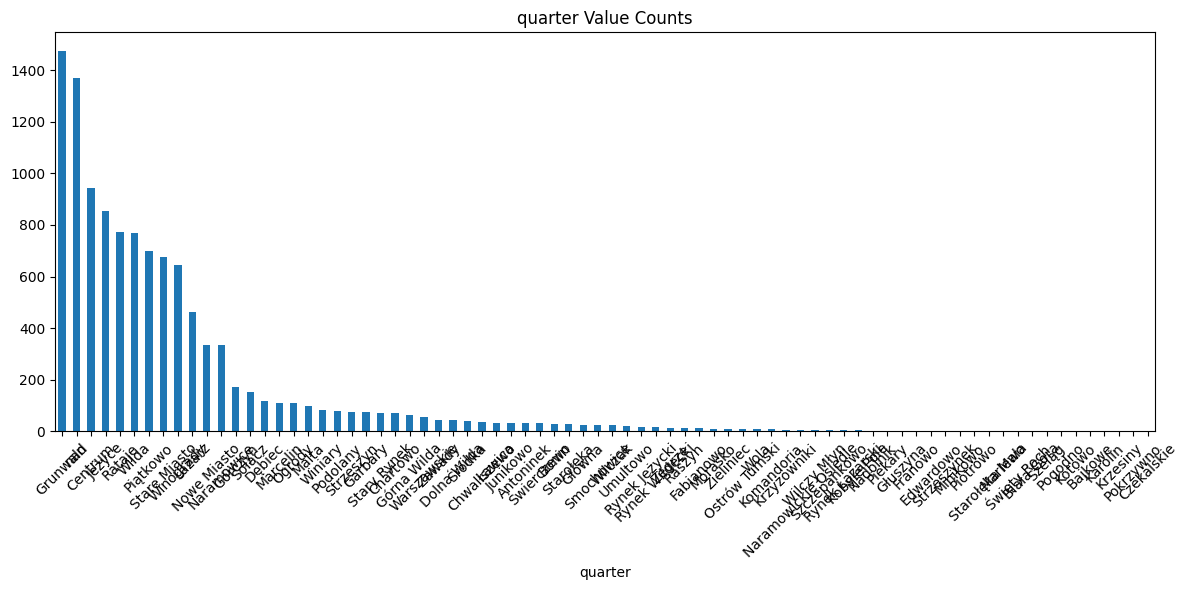

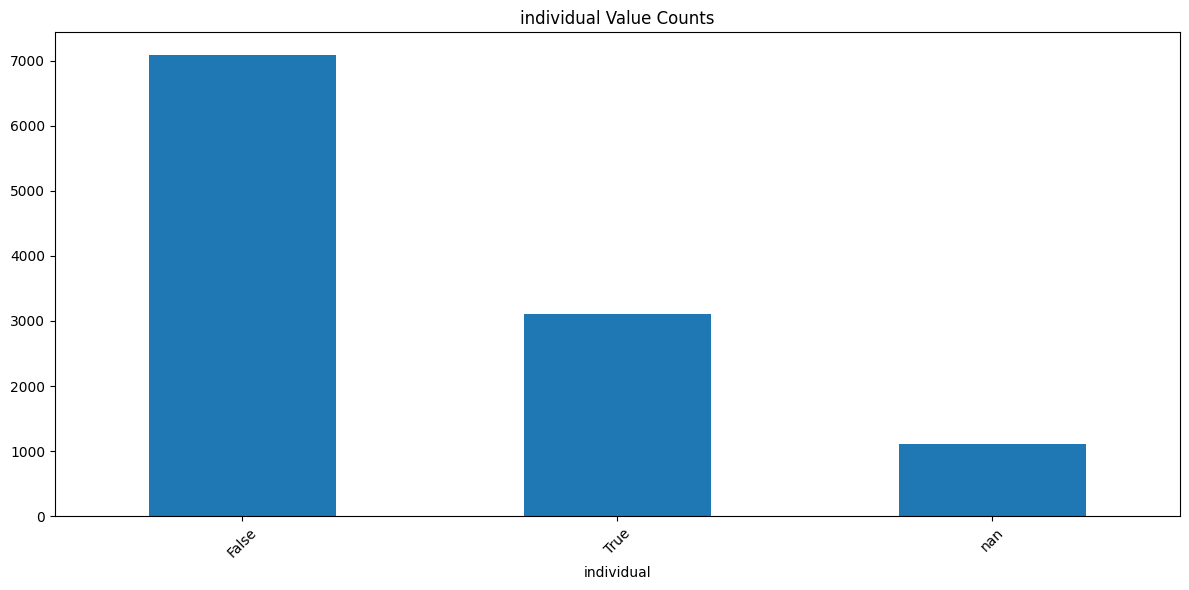

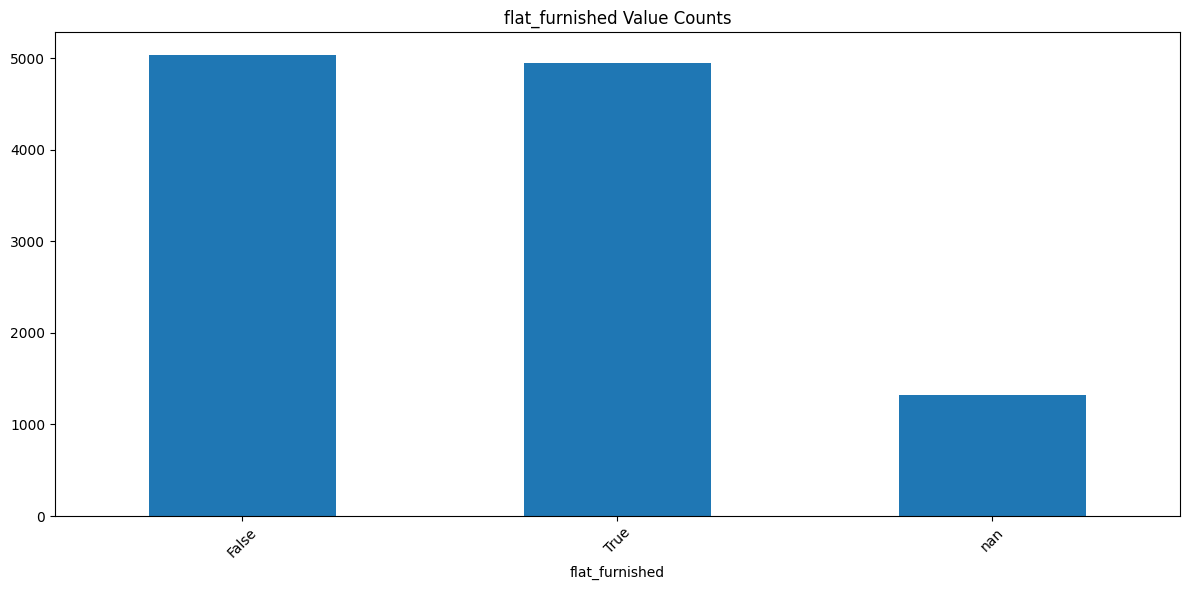

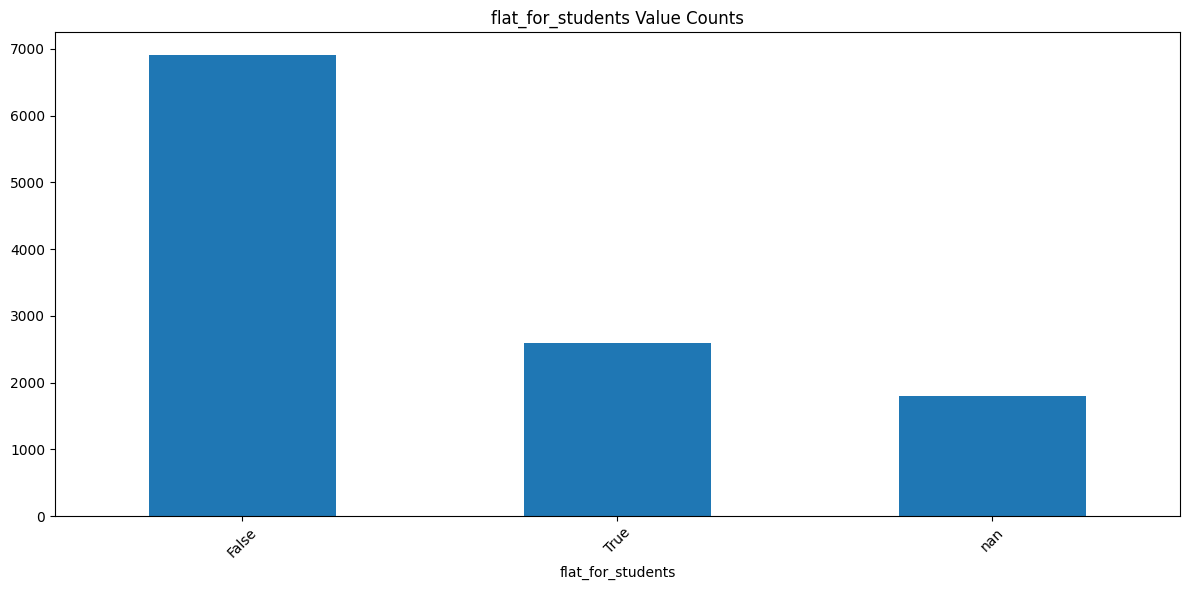

In [70]:
# Categorical analysis
def plot_categorical_counts(df, columns, figsize=(12, 6)):
    """Plot value counts for categorical columns"""
    for col in columns:
        plt.figure(figsize=figsize)
        df[col].value_counts(dropna=False).plot(kind='bar')
        plt.title(f'{col} Value Counts')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

categorical_columns = ['quarter', 'individual', 'flat_furnished', 'flat_for_students']
plot_categorical_counts(df, categorical_columns)

In [71]:
def engineer_features(df):
    df_processed = df.copy()
    
    # Date features
    df_processed['listing_month'] = pd.to_datetime(df_processed['date_activ']).dt.month
    df_processed['listing_day_of_week'] = pd.to_datetime(df_processed['date_activ']).dt.dayofweek
    df_processed['listing_duration'] = (
        pd.to_datetime(df_processed['date_expire']) - 
        pd.to_datetime(df_processed['date_activ'])
    ).dt.days
    
    # Amenities count
    amenity_columns = [col for col in df_processed.columns if col.startswith('flat_') and df_processed[col].dtype == bool]
    df_processed['amenities_count'] = df_processed[amenity_columns].sum(axis=1)
    
    # Amenity groups
    df_processed['basic_amenities'] = df_processed[['flat_fridge', 'flat_cooker', 'flat_oven']].sum(axis=1)
    df_processed['comfort_amenities'] = df_processed[['flat_washmachine', 'flat_dishwasher', 'flat_air_cond']].sum(axis=1)
    df_processed['outdoor_features'] = df_processed[['flat_balcony', 'flat_garden', 'flat_tarrace']].sum(axis=1)
    
    # Floor features
    df_processed['is_ground_floor'] = df_processed['building_floor_num'] == 1
    df_processed['is_top_floor'] = df_processed['building_floor_num'] >= 10
    
    # Room efficiency
    df_processed['area_per_room'] = df_processed['flat_area'] / df_processed['flat_rooms']
    
    return df_processed

df_engineered = engineer_features(df)

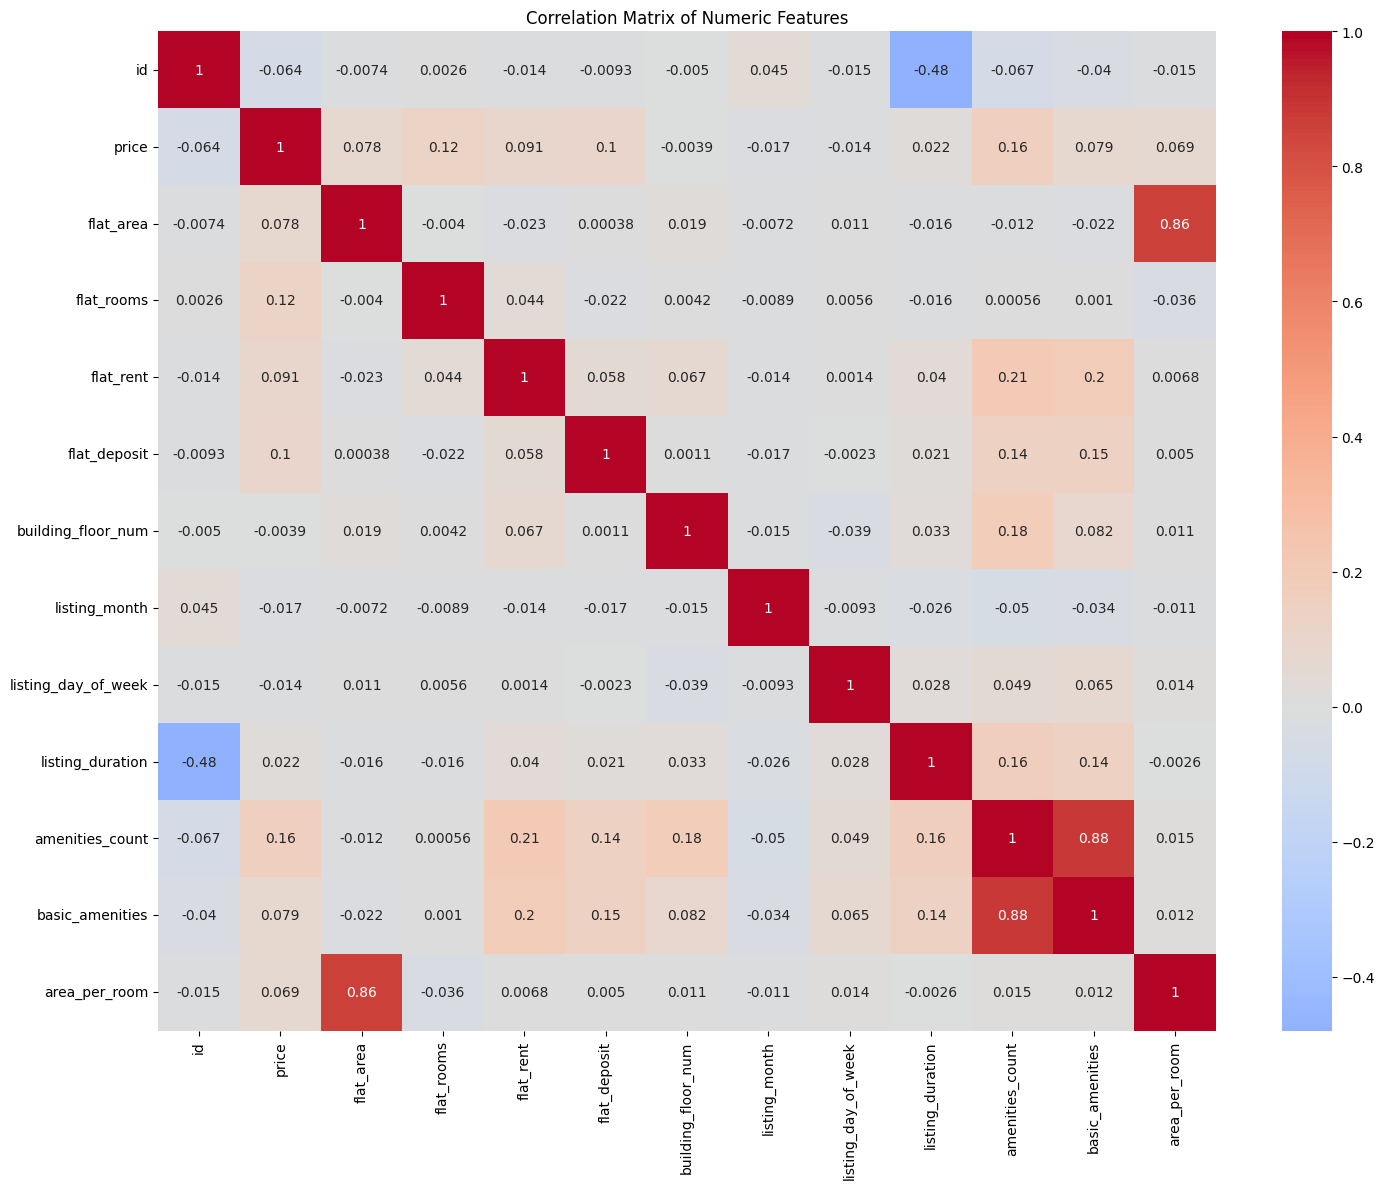

In [72]:
# Correlation 
numeric_cols = df_engineered.select_dtypes(include=[np.number]).columns
correlation_matrix = df_engineered[numeric_cols].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

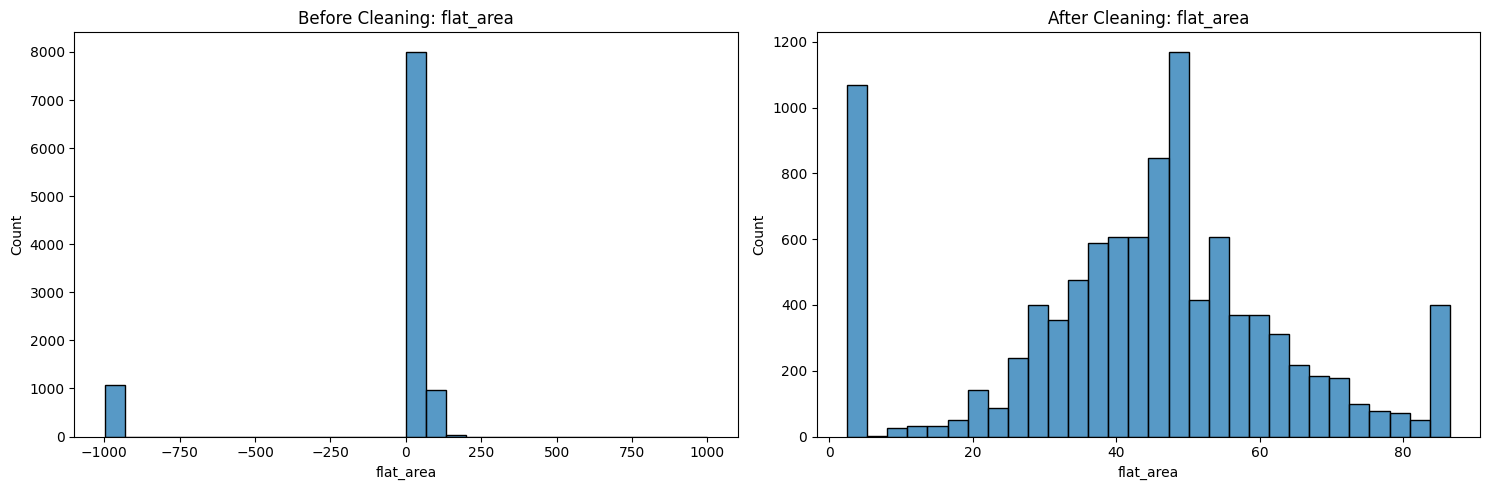

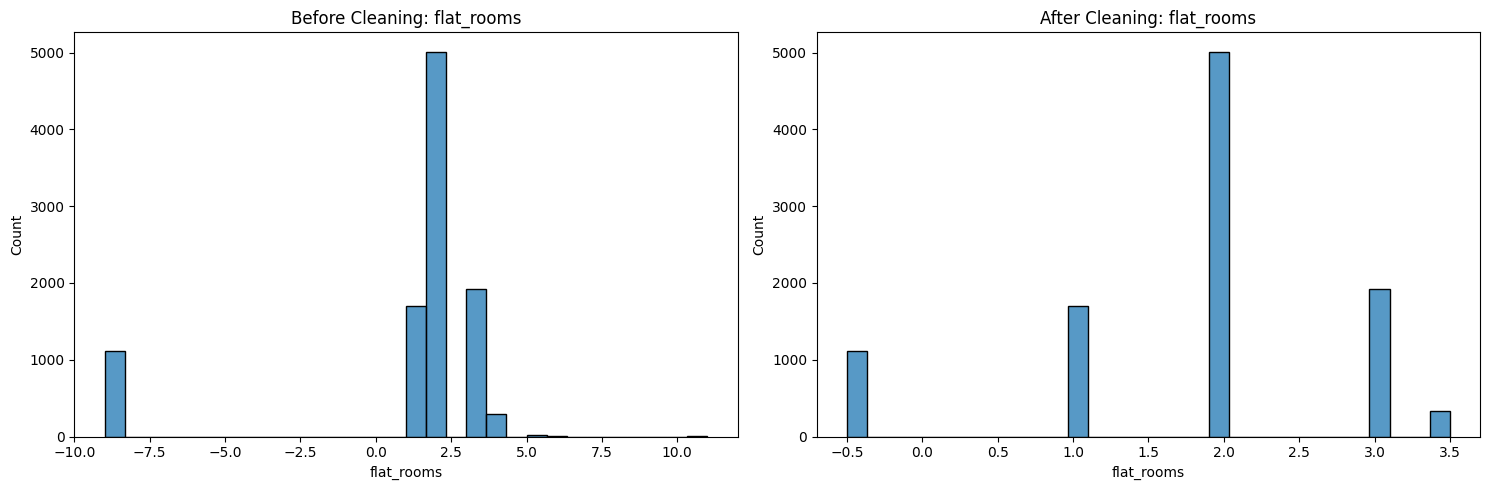

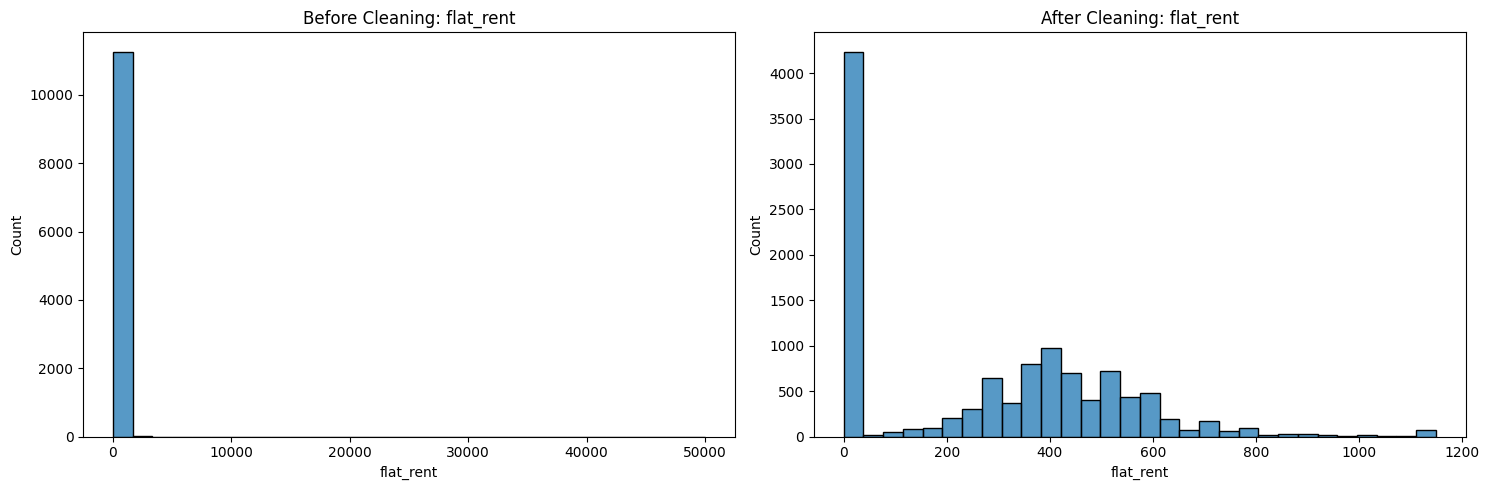

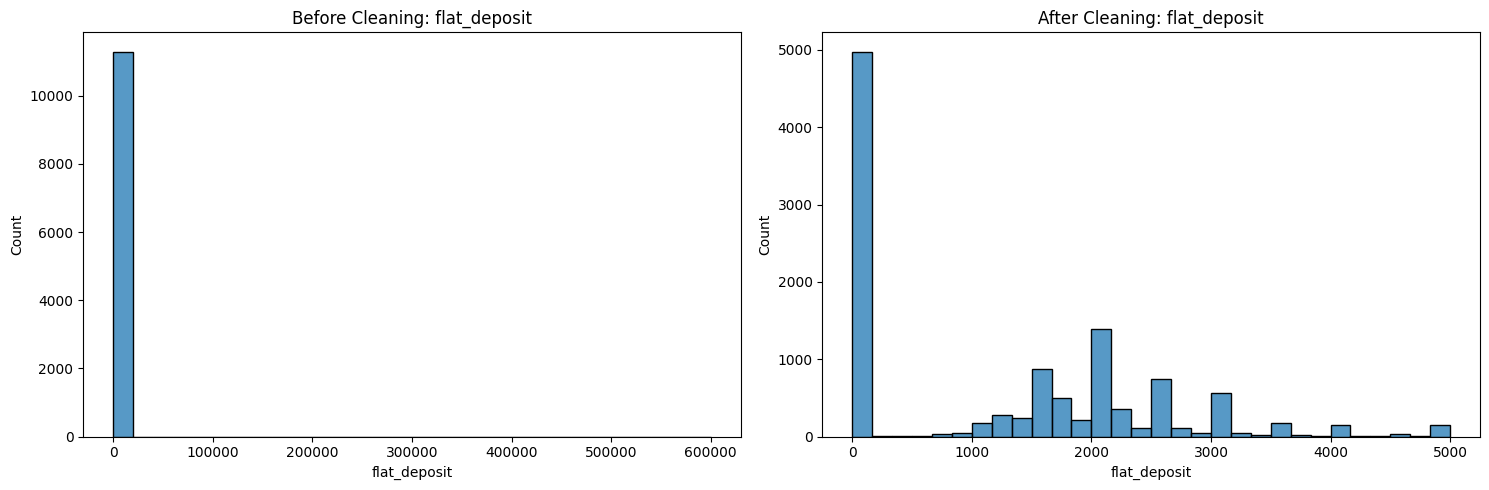

In [73]:
# Outliers
def handle_outliers(df, columns):
    """Handle outliers using IQR method"""
    df_cleaned = df.copy()
    
    for col in columns:
        q1 = df_cleaned[col].quantile(0.25)
        q3 = df_cleaned[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df_cleaned[col] = df_cleaned[col].clip(lower_bound, upper_bound)
    
    return df_cleaned

# Handle outliers in numeric columns
numeric_columns = [
    #'price',
    'flat_area', 'flat_rooms', 'flat_rent', 'flat_deposit']
df_cleaned = handle_outliers(df_engineered, numeric_columns)

# Compare distributions before and after cleaning
for col in numeric_columns:
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(data=df_engineered, x=col, bins=30)
    plt.title(f'Before Cleaning: {col}')
    
    plt.subplot(1, 2, 2)
    sns.histplot(data=df_cleaned, x=col, bins=30)
    plt.title(f'After Cleaning: {col}')
    
    plt.tight_layout()
    plt.show()

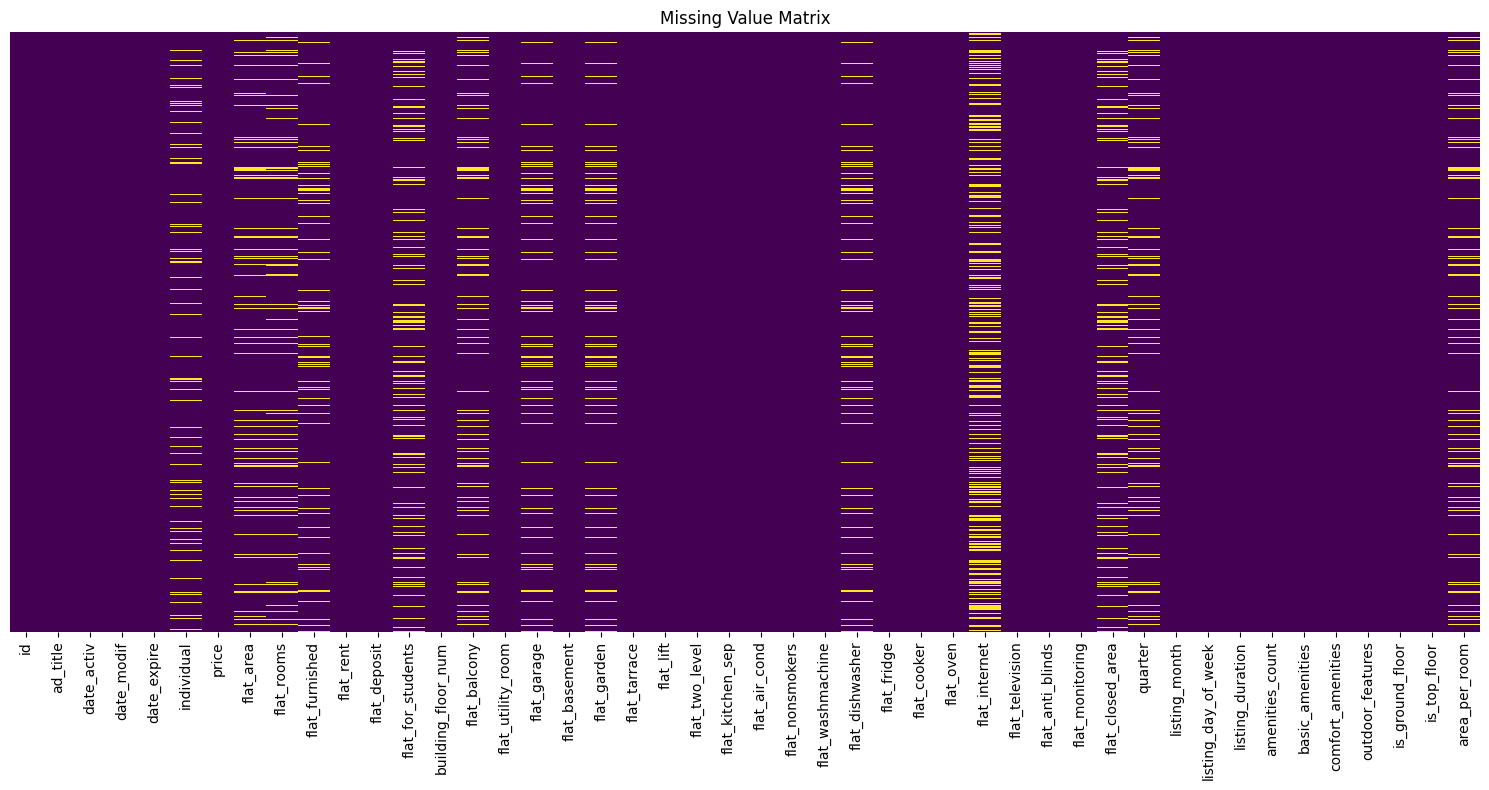

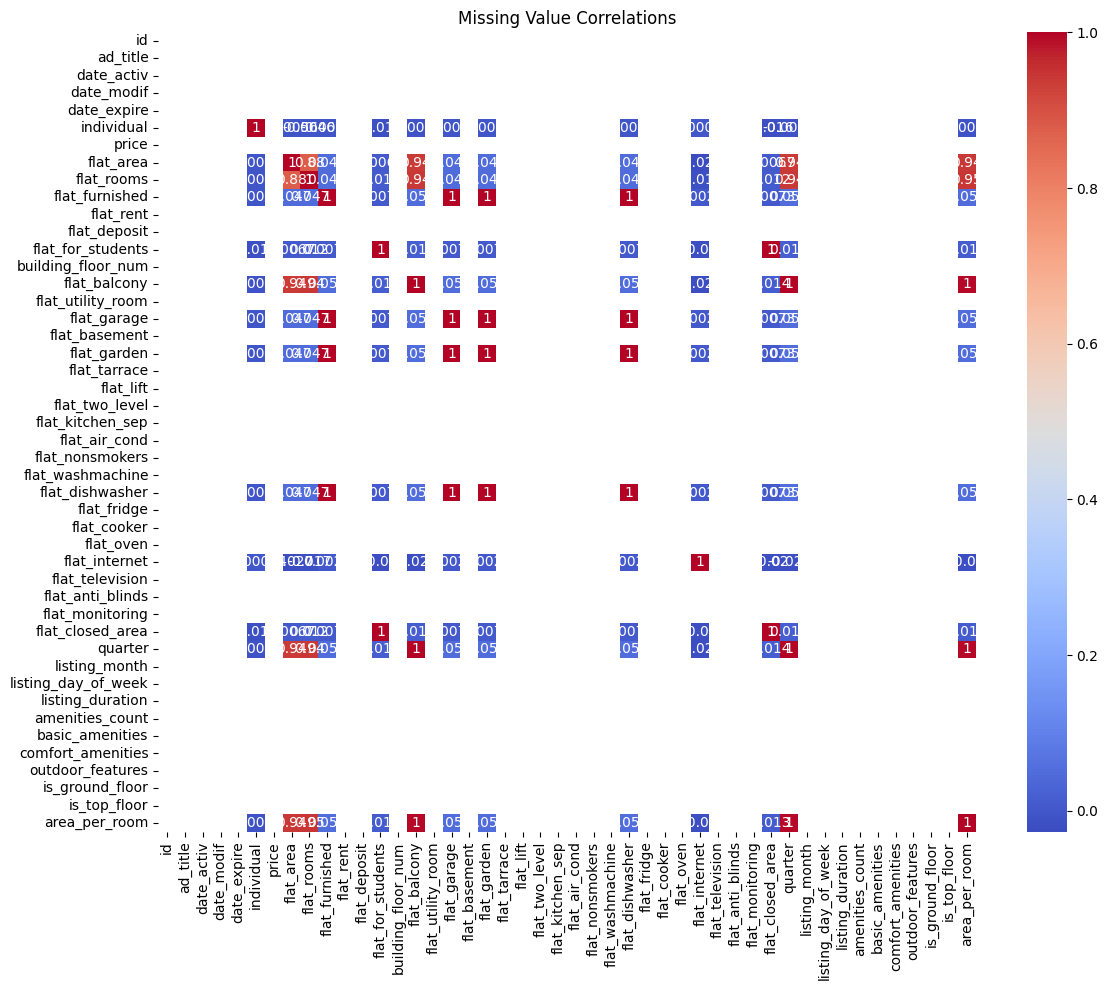

In [74]:
# Missing value patterns
def analyze_missing_patterns(df):
    """Analyze patterns in missing values"""
    # Missing value matrix
    plt.figure(figsize=(15, 8))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
    plt.title('Missing Value Matrix')
    plt.tight_layout()
    plt.show()
    
    # Missing value correlations
    missing_correlations = df.isnull().corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(missing_correlations, annot=True, cmap='coolwarm')
    plt.title('Missing Value Correlations')
    plt.tight_layout()
    plt.show()

analyze_missing_patterns(df_cleaned)

In [75]:
# Remove unnecessary columns
columns_to_drop = ['ad_title', 'date_activ', 'date_modif', 'date_expire']
df_final = df_cleaned.drop(columns=columns_to_drop)

# Convert boolean columns to integers
boolean_cols = df_final.select_dtypes(include=['bool']).columns
for col in boolean_cols:
    df_final[col] = df_final[col].astype(int)

# Save processed dataset
df_final.to_csv('../data/pzn-rent-test-processed.csv', index=False)
#df_final.to_csv('../data/pzn-rent-test-processed.csv', index=False)


print("\nProcessed dataset shape:", df_final.shape)
print("\nProcessed dataset columns:", df_final.columns.tolist())
print("\nMissing values in processed dataset:")
print(df_final.isnull().sum()[df_final.isnull().sum() > 0])


Processed dataset shape: (11297, 42)

Processed dataset columns: ['id', 'individual', 'price', 'flat_area', 'flat_rooms', 'flat_furnished', 'flat_rent', 'flat_deposit', 'flat_for_students', 'building_floor_num', 'flat_balcony', 'flat_utility_room', 'flat_garage', 'flat_basement', 'flat_garden', 'flat_tarrace', 'flat_lift', 'flat_two_level', 'flat_kitchen_sep', 'flat_air_cond', 'flat_nonsmokers', 'flat_washmachine', 'flat_dishwasher', 'flat_fridge', 'flat_cooker', 'flat_oven', 'flat_internet', 'flat_television', 'flat_anti_blinds', 'flat_monitoring', 'flat_closed_area', 'quarter', 'listing_month', 'listing_day_of_week', 'listing_duration', 'amenities_count', 'basic_amenities', 'comfort_amenities', 'outdoor_features', 'is_ground_floor', 'is_top_floor', 'area_per_room']

Missing values in processed dataset:
individual           1103
flat_area            1217
flat_rooms           1227
flat_furnished       1317
flat_for_students    1804
flat_balcony         1368
flat_garage          1317
f

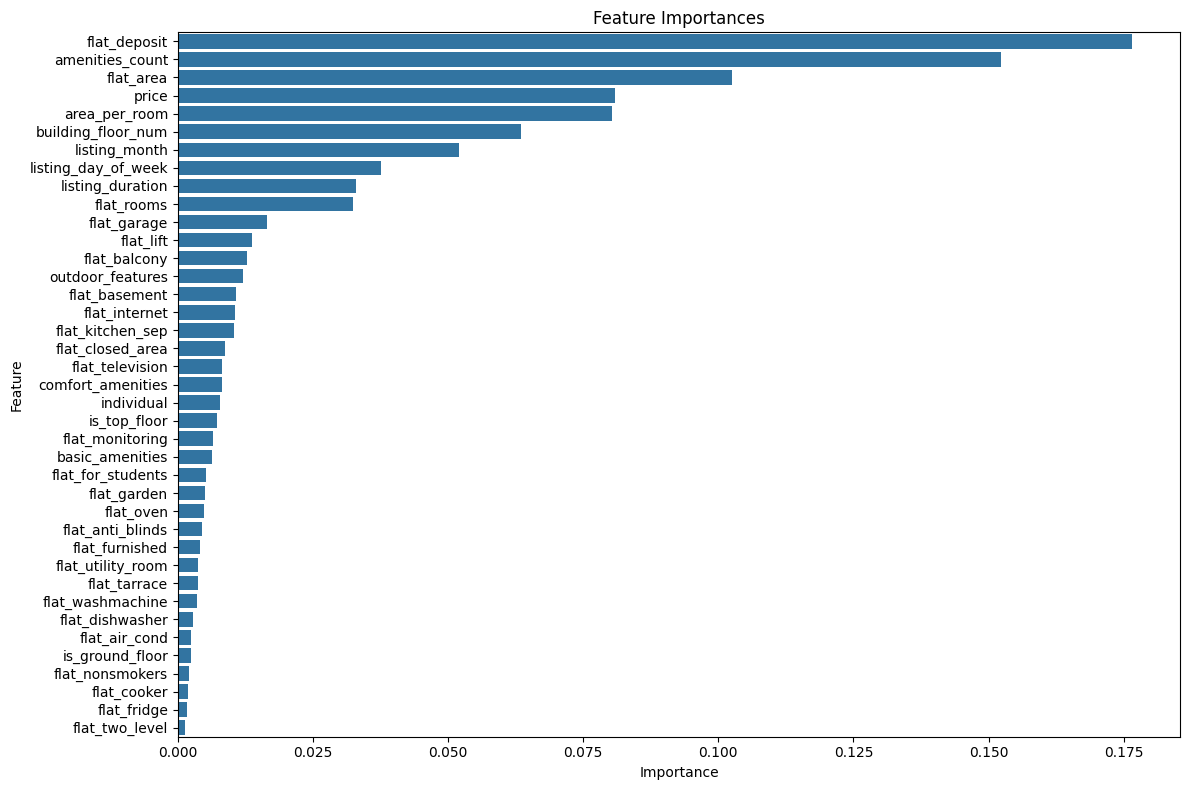

                Feature  Importance
5          flat_deposit    0.176602
32      amenities_count    0.152329
2             flat_area    0.102444
1                 price    0.080948
38        area_per_room    0.080388
7    building_floor_num    0.063479
29        listing_month    0.052001
30  listing_day_of_week    0.037547
31     listing_duration    0.032971
3            flat_rooms    0.032462
10          flat_garage    0.016471
14            flat_lift    0.013776
8          flat_balcony    0.012804
35     outdoor_features    0.011987
11        flat_basement    0.010753
24        flat_internet    0.010488
16     flat_kitchen_sep    0.010469
28     flat_closed_area    0.008778
25      flat_television    0.008232
34    comfort_amenities    0.008212
0            individual    0.007712
37         is_top_floor    0.007174
27      flat_monitoring    0.006491
33      basic_amenities    0.006254
6     flat_for_students    0.005119
12          flat_garden    0.005009
23            flat_oven    0

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

# Define the target variable and features
target = 'flat_rent'
features = df_final.drop(columns=[target, 'id', 'quarter']).columns

# Split the data into training and testing sets
X = df_final[features].dropna()
y = df_final.loc[X.index, target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the RandomForestRegressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

# Display the feature importances
print(feature_importances)